<a href="https://colab.research.google.com/github/quanghuydsai/Project-III/blob/main/SMILES_AutoEncoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch transformers pathlib rdkit tqdm torch_geometric

In [2]:
from google.colab import drive
from google.colab import files

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import re
class regexTokenizer():
    def __init__(self,vocab_path='/content/drive/MyDrive/LDMol/vocab_bpe_300_sc.txt',max_len=127):
        with open(vocab_path,'r') as f:
            x = f.readlines()
            x = [xx.replace('##', '') for xx in x]
            x2 = x.copy()
        x2.sort(key=len, reverse=True)
        pattern = "("+"|".join(re.escape(token).strip()[:-1] for token in x2)+")"
        self.rg = re.compile(pattern)

        self.idtotok  = { cnt:i.strip() for cnt,i in enumerate(x)}
        self.vocab_size = len(self.idtotok) #SOS, EOS, pad
        self.toktoid = { v:k for k,v in self.idtotok.items()}
        self.max_len = max_len
        self.cls_token_id = self.toktoid['[CLS]']
        self.sep_token_id = self.toktoid['[SEP]']
        self.pad_token_id = self.toktoid['[PAD]']

    def decode_one(self, iter):
        if self.sep_token_id in iter:   iter = iter[:(iter == self.sep_token_id).nonzero(as_tuple=True)[0][0].item()]
        # return "".join([self.ind2Letter(i) for i in iter]).replace('[SOS]','').replace('[EOS]','').replace('[PAD]','')
        return "".join([self.idtotok[i.item()] for i in iter[1:]])

    def decode(self,ids:torch.tensor):
        if len(ids.shape)==1:
            return [self.decode_one(ids)]
        else:
            smiles  = []
            for i in ids:
                smiles.append(self.decode_one(i))
            return smiles
    def __len__(self):
        return self.vocab_size

    def __call__(self,smis:list, truncation='max_len'):
        tensors = []
        lengths = []
        if type(smis) is str:
            smis = [smis]
        for i in smis:
            length, tensor = self.encode_one(i)
            tensors.append(tensor)
            lengths.append(length)
        output = torch.concat(tensors,dim=0)
        if truncation == 'max_len':
            return output
        elif truncation == 'longest':
            return output[:, :max(lengths)]
        else:
            raise ValueError('truncation should be either max_len or longest')

    def encode_one(self, smi):
        smi = '[CLS]' + smi + '[SEP]'
        res = [self.toktoid[i] for i in self.rg.findall(smi)]
        token_length = len(res)
        if token_length < self.max_len:
            res += [self.pad_token_id]*(self.max_len-len(res))
        else:
            res = res[:self.max_len]
            # res[-1] = self.sep_token_id
        return token_length, torch.LongTensor([res])

In [4]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [5]:
from abc import abstractmethod
from random import shuffle
from typing import Any
from typing import Iterable
from typing import List
from typing import Union

import numpy as np
from rdkit import Chem

In [6]:
Mol = Chem.Mol
class Augmenter:
    """An abstract base class for molecular augmenters.

    The class has one method, `augment`, which is overriden by child classes.
    It is possible to call the class with either a list of molecules or a single
    molecules. This input will then be passed to `augment` and the augmented
    molecule(s) will be returned.
    The Boolean ".active" property can be set to toggle augmentation.

    :param active: Whether the augmentation should be active or not, defaults to True.
    :param augment_prob: if lower than 1, it is used to randomly turn-off augmentation on an individual basis
    """

    def __init__(self, active: bool = True, augment_prob: float = 1.0) -> None:
        self.active = active
        self.augment_prob = augment_prob

    def __call__(self, data: Union[Iterable[Any], Any]) -> List[Any]:
        """Augments either a list of Anys or a single molecule by making sure
        the input is put into a `List` and then passed to the `augment` function.

        :param data: Either a list of molecules or a single molecules to be augmented.

        :return: A list of augmented molecules.
        """
        # Str is Iterable but must be encapsulated (e.g. single SMILES string)
        if not isinstance(data, Iterable) or isinstance(data, str):
            data = [data]

        return self.augment(data)

    @abstractmethod
    def _augment(self, data: Iterable[Any]) -> List[Any]:
        raise NotImplementedError()

    def augment(self, data: Iterable[Any]) -> List[Any]:
        """
        Augment a given list

        :param data: a list of molecules to be augmented.
        :return: A list of augmented molecules.
        """
        if self.active:
            return self._augment(data)
        return list(data)
class MolAugmenter(Augmenter):
    """
    Augmenter that works on RDKit Mol objects
    """

    def randomize_mols_restricted(self, mols: Iterable[Mol]) -> List[Mol]:
        """Randomizes the atom ordering of a list of RDKit molecules (`rdkit.Chem.Mol`:s).

        :param mols: List of RDKit molecules to be augmented.
        :return:  List of augmented RDKit molecules.
        """
        return list(map(self.randomize_mol_restricted, mols))

    def randomize_mol_restricted(self, mol: Mol) -> Mol:
        """Randomize the atom ordering of a RDKit molecule (`rdkit.Chem.Mol`).

        :param mol:  RDKit molecule to get a randomized atom order.
        :return: RDKit molecule object with a randomized atom-order.
        """
        # Standard shuffle surprisingly leads to 35% slower code.
        if self.augment_prob < np.random.rand():
            return mol
        atom_order: List[int] = list(range(mol.GetNumAtoms()))
        np.random.shuffle(atom_order)
        return Chem.RenumberAtoms(mol, atom_order)

    def _augment(self, data: Iterable[Mol]) -> List[Mol]:
        """Randomizes `RDKit molecules by shuffling the atom order.

        :param data: List of RDKit molecules to be randomized.
        :return:  A list of randomized molecules.
        """
        return self.randomize_mols_restricted(data)

In [7]:
from torch.utils.data import Dataset
import random
from rdkit import Chem, RDLogger
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers

In [8]:
class SMILESDataset_pretrain(Dataset):
    def __init__(self, data_list, data_length=None, shuffle=False, is_train=True):
        """
        Args:
            data_list: Danh sách chứa các dict (ldmol_dataset)
            data_length: List [start, end] để cắt dữ liệu nếu cần
            shuffle: Trộn dữ liệu
            is_train: Chế độ huấn luyện hay đánh giá
        """
        # Cắt dữ liệu theo data_length nếu có yêu cầu
        if data_length is not None:
            self.data = data_list[data_length[0] : data_length[1]]
        else:
            self.data = data_list

        if shuffle:
            random.shuffle(self.data)

        self.train = is_train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Lấy SMILES từ dictionary 'smiles'
        smiles = self.data[index]['smiles']
        smiles2 = smiles

        # Logic tạo đồng phân lập thể (Stereoisomers)
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                # Tạo danh sách các đồng phân lập thể
                sc_list = list(EnumerateStereoisomers(mol))

                if self.train and len(sc_list) > 1:
                    # Lấy 2 đồng phân khác nhau cho Contrastive Learning
                    mol_a, mol_b = random.sample(sc_list, k=2)
                    smiles = Chem.MolToSmiles(mol_a, canonical=True, isomericSmiles=True)
                    smiles2 = Chem.MolToSmiles(mol_b, canonical=True, isomericSmiles=True)
                else:
                    # Lấy ngẫu nhiên 1 đồng phân
                    mol_selected = random.choice(sc_list)
                    smiles = Chem.MolToSmiles(mol_selected, canonical=True, isomericSmiles=True)
                    smiles2 = smiles
        except Exception as e:
            # Nếu lỗi RDKit, giữ nguyên smiles ban đầu
            pass

        # Trả về định dạng chuỗi để tokenizer xử lý (kết hợp bằng ký tự 'Q' như code gốc của bạn)
        if self.train and smiles2 != smiles:
            return f"[CLS]{smiles}Q[CLS]{smiles2}"

        return f"[CLS]{smiles}"

In [9]:
from transformers.models.bert.configuration_bert import BertConfig

In [10]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import copy
import sys
import os
from transformers import BertConfig, BertModel
from transformers.models.bert.modeling_bert import BertOnlyMLMHead
import matplotlib.pyplot as plt

In [11]:
enc_config = BertConfig(
    hidden_size=1024, num_hidden_layers=12, num_attention_heads=16,
    intermediate_size=3072, hidden_act="gelu", vocab_size=300,
    max_position_embeddings=512
)

In [12]:
dec_config = BertConfig(
    hidden_size=768, num_hidden_layers=12, num_attention_heads=12,
    intermediate_size=3072, hidden_act="gelu", vocab_size=300,
    max_position_embeddings=512, encoder_width=1024,
    add_cross_attention=True, # QUAN TRỌNG: Để nhận encoder_hidden_states
    is_decoder=True           # QUAN TRỌNG: Để hoạt động như một Decoder
)

In [13]:
paths = {
    'encoder_checkpoint': '/content/drive/MyDrive/LDMol/Checkpoint/best_encoder.pt',
    'vocab': '/content/drive/MyDrive/LDMol/vocab_bpe_300_sc.txt',
    'checkpoint_dir': '/content/drive/MyDrive/LDMol/Checkpoint'
}

In [14]:
class CustomBertLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        # add_pooling_layer=False vì chúng ta dùng cho Masked LM
        self.bert = BertModel(config, add_pooling_layer=False)
        self.cls = BertOnlyMLMHead(config)

    def forward(self, input_ids, attention_mask, encoder_hidden_states):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=encoder_hidden_states, # Nhận vector từ Encoder
            return_dict=True
        )
        sequence_output = outputs.last_hidden_state
        prediction_scores = self.cls(sequence_output)
        return prediction_scores

In [15]:
class SMILESAutoencoder(nn.Module):
    def __init__(self, enc_cfg, dec_cfg, checkpoint_path=None):
        super().__init__()
        self.encoder = BertModel(enc_cfg, add_pooling_layer=False)
        self.decoder = CustomBertLM(dec_cfg)

        # --- SỬA LỖI TẠI ĐÂY ---
        # Lớp nén: Từ 1024 (Encoder) xuống 64
        self.encode_prefix = nn.Linear(enc_cfg.hidden_size, 64)
        # Lớp giải nén: Từ 64 lên 768 (Phải khớp với Hidden Size của Decoder)
        self.decode_prefix = nn.Linear(64, dec_cfg.hidden_size)

        # Nạp trọng số (Giữ nguyên logic cũ)
        if checkpoint_path and os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location='cpu')
            state_dict = checkpoint.get('model', checkpoint.get('state_dict', checkpoint))
            clean_sd = {k.replace('text_encoder.', '').replace('bert.', ''): v
                        for k, v in state_dict.items() if 'cls' not in k}
            self.encoder.load_state_dict(clean_sd, strict=False)

        for param in self.encoder.parameters():
            param.requires_grad = False

    def forward(self, ids, mask):
        # 1. Encoding -> Output shape: [Batch, Seq, 1024]
        with torch.no_grad():
            enc_out = self.encoder(ids, attention_mask=mask).last_hidden_state

        # 2. Bottleneck
        # Nén 1024 -> 64
        latent = self.encode_prefix(enc_out)
        # Giải nén 64 -> 768 (Để nạp vào Decoder có hidden_size 768)
        dec_input_context = self.decode_prefix(latent)

        # 3. Decoding
        labels = ids.clone()[:, 1:]
        # Truyền dec_input_context (768) vào làm encoder_hidden_states
        logits = self.decoder(ids[:, :-1], mask[:, :-1], dec_input_context)
        return logits, labels

In [16]:
from torch_geometric.data import InMemoryDataset
class PubChemDataset(InMemoryDataset):
    def __init__(self, path):
        super(PubChemDataset, self).__init__()
        self.data, self.slices = torch.load(path, weights_only=False)

    def __getitem__(self, idx):
        return self.get(idx)

In [17]:
raw_dataset = PubChemDataset('/content/drive/MyDrive/LDMol/train.pt')

In [18]:
ldmol_dataset = []
for data in raw_dataset:
    ldmol_dataset.append({
            'smiles': data.smiles,
            'text': data.text
        })

In [19]:
print(ldmol_dataset[0:2])

[{'smiles': 'C1=CC=C(C=C1)C(CN)O', 'text': 'The molecule is the simplest member of the class of phenylethanolamines that is 2-aminoethanol bearing a phenyl substituent at the 1-position. The parent of the phenylethanolamine class. It has a role as a human metabolite. It is a conjugate base of a phenylethanolaminium.\nThe molecule is a natural product found in Peucedanum palustre, Pseudo-nitzschia multistriata, and other organisms with data available.\nThe molecule is also used in chemical industry.'}, {'smiles': 'CC(=C)C(CC1=C2C(=C(C3=C1OC4=C(C3=O)C=C(C=C4)O)O)C=CC(O2)(C)C)OO', 'text': 'The molecule is a member of the class of pyranoxanthones that is 2H,6H-pyrano[3,2-b]xanthen-6-one substituted by a 2-hydroperoxy-3-methylbut-3-en-1-yl moiety at position 12, hydroxy groups at positions 5 and 8 and geminal methyl groups at position 2. It is isolated from the stem bark of Calophyllum brasiliense and exhibits significant inhibitory activity against 12-O-tetradecanoylphorbol-13-acetate indu

In [20]:
def plot_training_metrics(history):
    # Biểu đồ 1: Loss progression theo step
    plt.figure(figsize=(10, 4))
    plt.plot(history['steps'], history['step_losses'], color='red', label='Loss per 100 steps')
    plt.title('Loss Progression (by Step)')
    plt.xlabel('Global Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Biểu đồ 2: Learning rate theo step
    plt.figure(figsize=(10, 4))
    plt.plot(history['steps'], history['step_lrs'], color='blue', label='Learning Rate')
    plt.title('Learning Rate Schedule (by Step)')
    plt.xlabel('Global Steps')
    plt.ylabel('LR')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [21]:
def train():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokenizer = regexTokenizer(vocab_path=paths['vocab'], max_len=127)
    dataset = SMILESDataset_pretrain(ldmol_dataset, shuffle=True)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = SMILESAutoencoder(enc_config, dec_config, paths['encoder_checkpoint']).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.5e-4, weight_decay=0.02)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)
    criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')

    # Lưu dữ liệu theo step để vẽ biểu đồ chi tiết
    history = {'steps': [], 'step_losses': [], 'step_lrs': [], 'epoch_avg_losses': []}
    best_loss = float('inf')
    global_step = 0

    print("Bắt đầu huấn luyện...")
    for epoch in range(10):
        model.train()
        epoch_loss = 0

        for batch_idx, text in enumerate(dataloader):
            global_step += 1
            ids = tokenizer(text, truncation='longest').to(device)
            mask = (ids != 0).long().to(device)

            logits, labels = model(ids, mask)
            loss = criterion(logits.permute(0, 2, 1), labels)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            epoch_loss += loss.item()

            # Ghi lại dữ liệu mỗi 100 steps
            if global_step % 100 == 0:
                curr_lr = optimizer.param_groups[0]['lr']
                history['steps'].append(global_step)
                history['step_losses'].append(loss.item())
                history['step_lrs'].append(curr_lr)
                print(f"Step: {global_step} | Epoch: {epoch+1} | Loss: {loss.item():.4f} | LR: {curr_lr:.8f}")

        # Sau mỗi epoch
        avg_loss = epoch_loss / len(dataloader)
        history['epoch_avg_losses'].append(avg_loss)

        print(f"\n--- KẾT THÚC EPOCH {epoch+1} ---")
        print(f"Average Loss: {avg_loss:.4f}")

        # VẼ BIỂU ĐỒ SAU MỖI EPOCH
        plot_training_metrics(history)

        scheduler.step()

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), os.path.join(paths['checkpoint_dir'], 'best_autoencoder.pt'))
            print(f"Lưu model tốt nhất tại: {avg_loss:.4f}")

Bắt đầu huấn luyện...
Step: 100 | Epoch: 1 | Loss: 3236.4963 | LR: 0.00005000
Step: 200 | Epoch: 1 | Loss: 2734.5781 | LR: 0.00005000
Step: 300 | Epoch: 1 | Loss: 2302.2239 | LR: 0.00005000

--- KẾT THÚC EPOCH 1 ---
Average Loss: 2761.6152


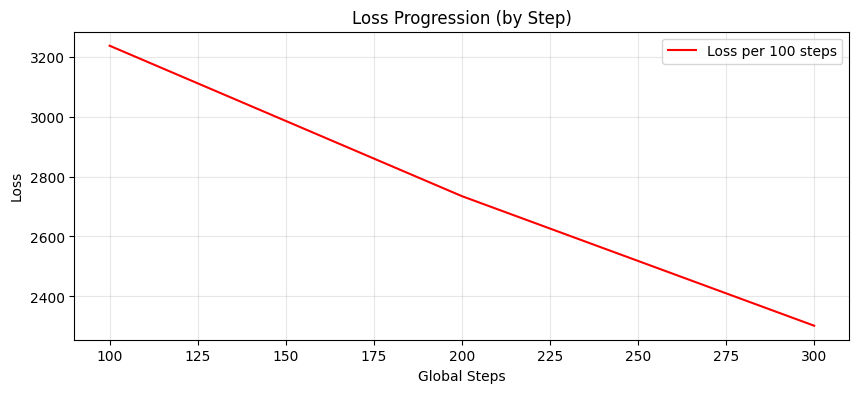

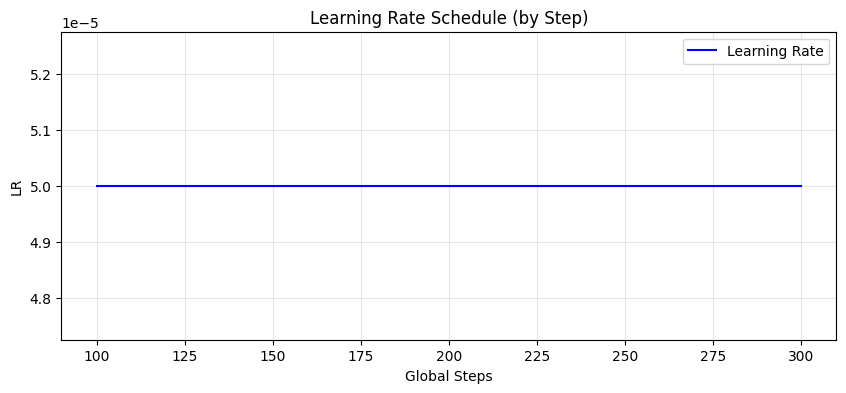

Lưu model tốt nhất tại: 2761.6152
Step: 400 | Epoch: 2 | Loss: 1897.4789 | LR: 0.00004902
Step: 500 | Epoch: 2 | Loss: 2297.8809 | LR: 0.00004902
Step: 600 | Epoch: 2 | Loss: 1915.8943 | LR: 0.00004902
Step: 700 | Epoch: 2 | Loss: 1913.7172 | LR: 0.00004902

--- KẾT THÚC EPOCH 2 ---
Average Loss: 1992.0866


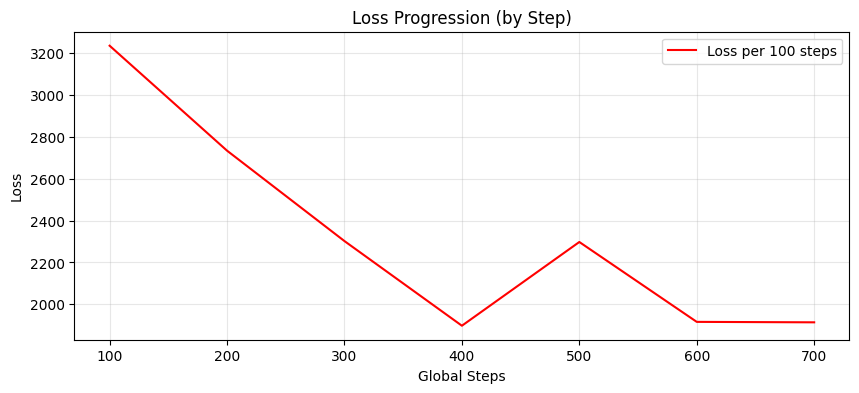

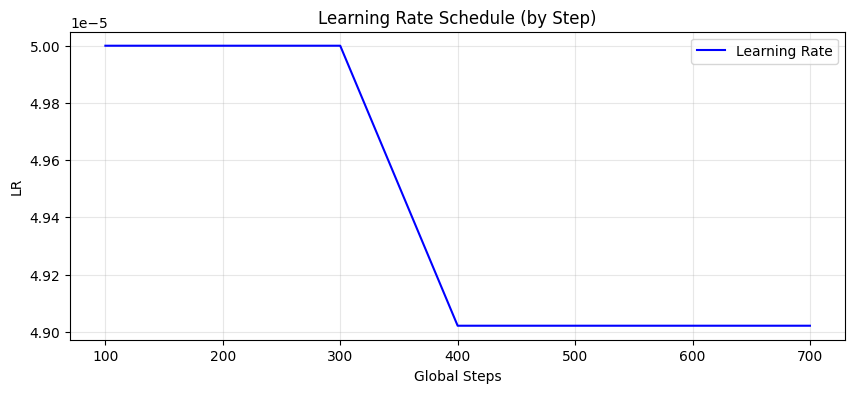

Lưu model tốt nhất tại: 1992.0866
Step: 800 | Epoch: 3 | Loss: 2060.8149 | LR: 0.00004618
Step: 900 | Epoch: 3 | Loss: 1769.1959 | LR: 0.00004618
Step: 1000 | Epoch: 3 | Loss: 1260.5254 | LR: 0.00004618
Step: 1100 | Epoch: 3 | Loss: 1537.0452 | LR: 0.00004618

--- KẾT THÚC EPOCH 3 ---
Average Loss: 1674.6365


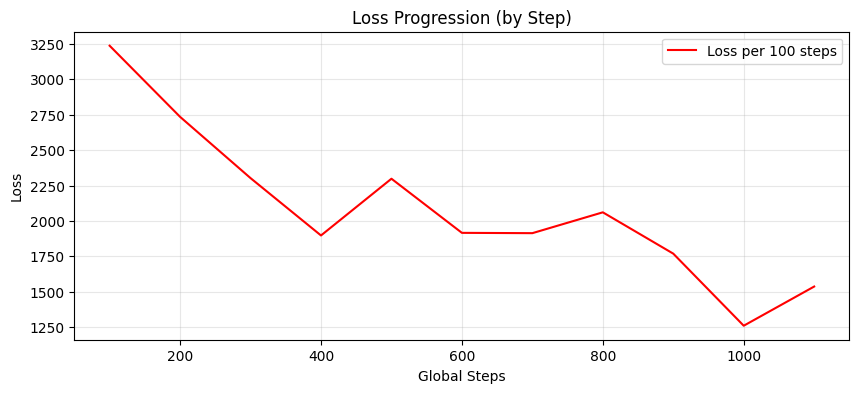

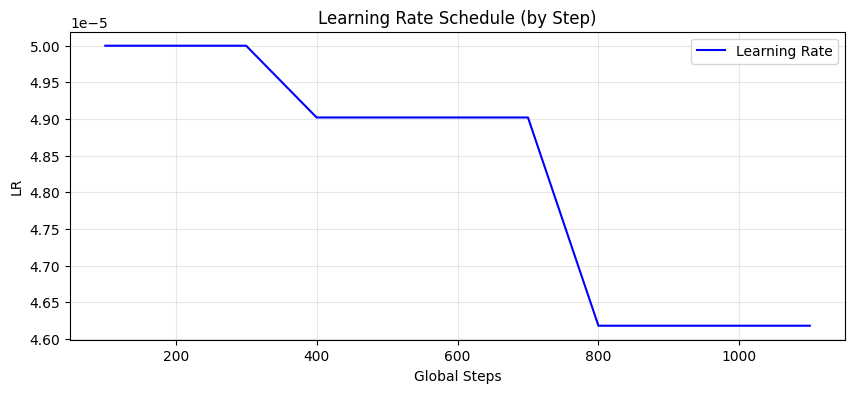

Lưu model tốt nhất tại: 1674.6365
Step: 1200 | Epoch: 4 | Loss: 1255.0963 | LR: 0.00004176
Step: 1300 | Epoch: 4 | Loss: 1866.3695 | LR: 0.00004176
Step: 1400 | Epoch: 4 | Loss: 1499.3661 | LR: 0.00004176
Step: 1500 | Epoch: 4 | Loss: 1453.4237 | LR: 0.00004176

--- KẾT THÚC EPOCH 4 ---
Average Loss: 1465.9013


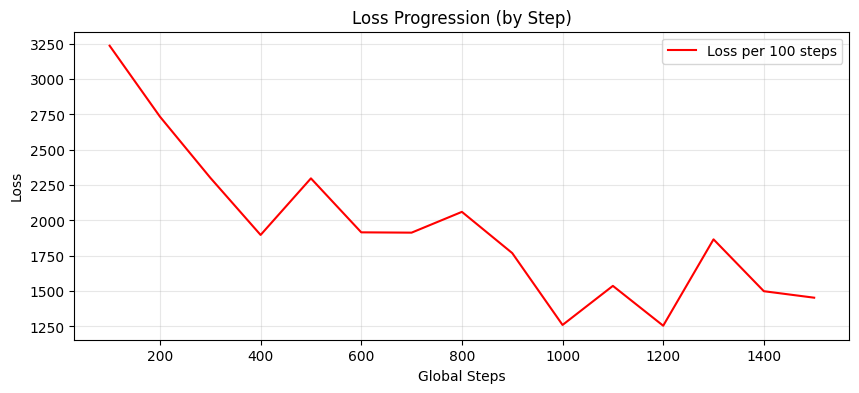

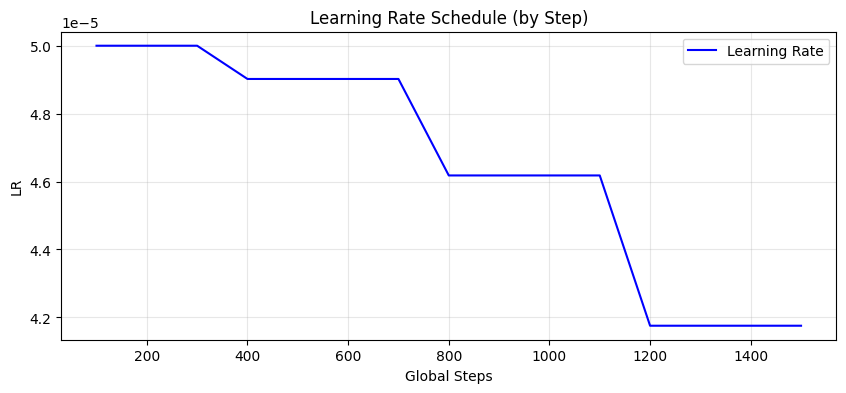

Lưu model tốt nhất tại: 1465.9013
Step: 1600 | Epoch: 5 | Loss: 1089.2955 | LR: 0.00003618
Step: 1700 | Epoch: 5 | Loss: 1594.5208 | LR: 0.00003618
Step: 1800 | Epoch: 5 | Loss: 1317.5303 | LR: 0.00003618

--- KẾT THÚC EPOCH 5 ---
Average Loss: 1299.1425


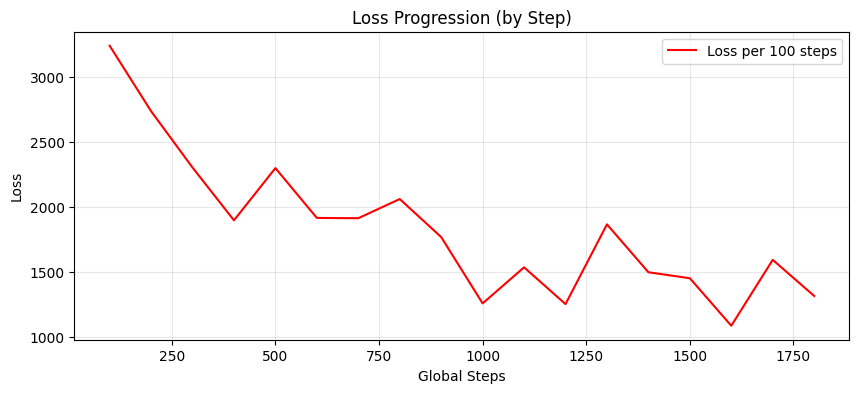

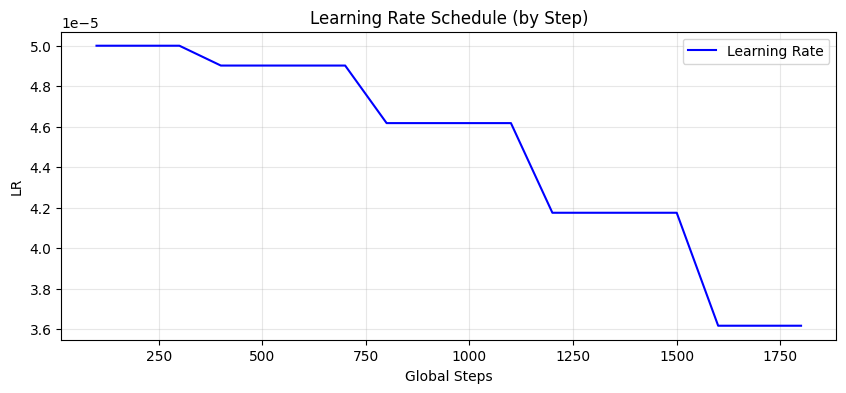

Lưu model tốt nhất tại: 1299.1425
Step: 1900 | Epoch: 6 | Loss: 1124.9314 | LR: 0.00003000
Step: 2000 | Epoch: 6 | Loss: 1251.5320 | LR: 0.00003000
Step: 2100 | Epoch: 6 | Loss: 980.9356 | LR: 0.00003000
Step: 2200 | Epoch: 6 | Loss: 897.9749 | LR: 0.00003000

--- KẾT THÚC EPOCH 6 ---
Average Loss: 1154.4690


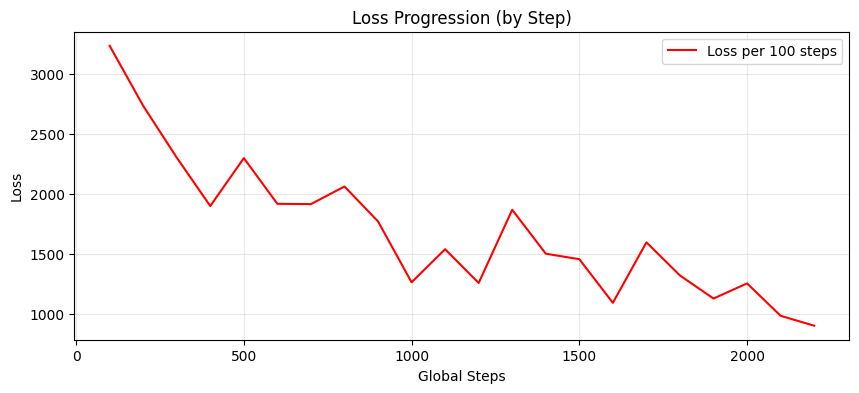

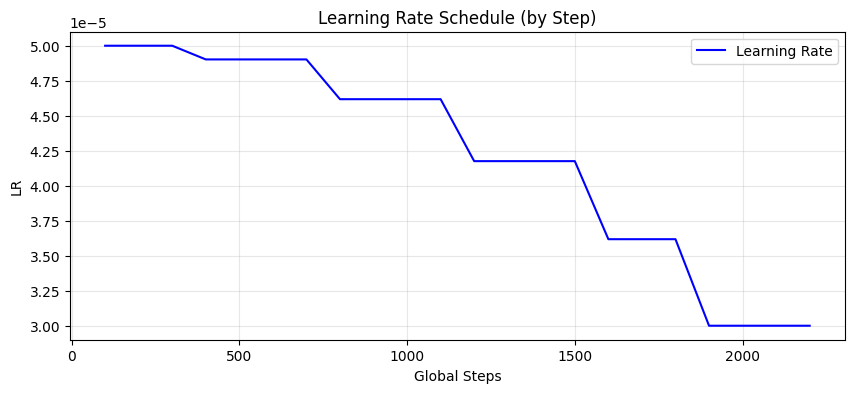

Lưu model tốt nhất tại: 1154.4690
Step: 2300 | Epoch: 7 | Loss: 710.2841 | LR: 0.00002382
Step: 2400 | Epoch: 7 | Loss: 948.4047 | LR: 0.00002382
Step: 2500 | Epoch: 7 | Loss: 1151.8151 | LR: 0.00002382
Step: 2600 | Epoch: 7 | Loss: 1346.2391 | LR: 0.00002382

--- KẾT THÚC EPOCH 7 ---
Average Loss: 1039.6883


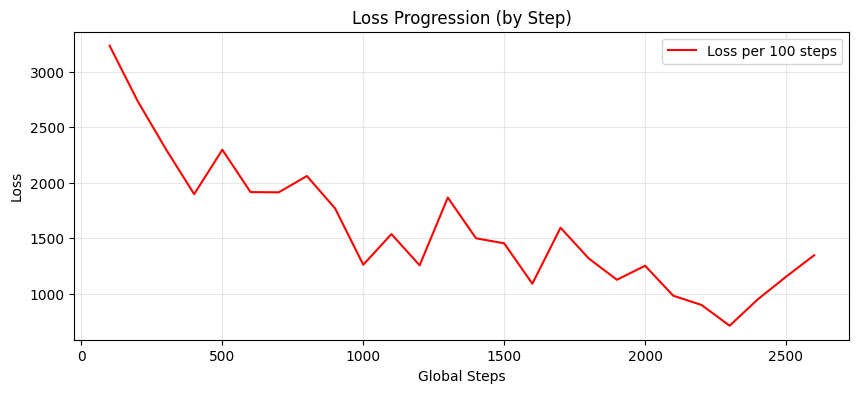

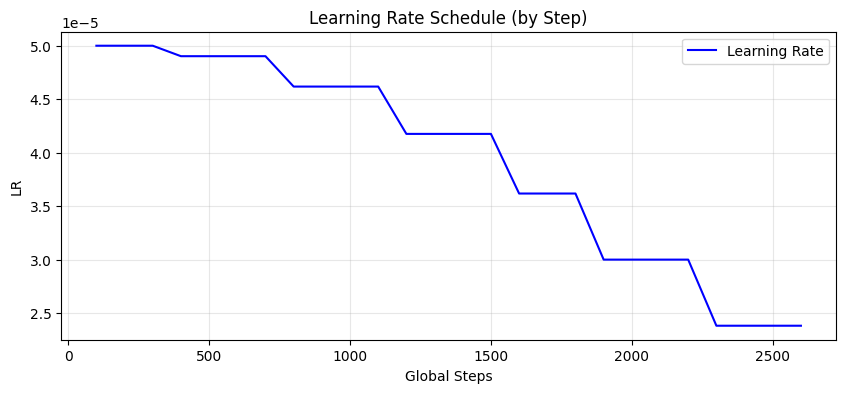

Lưu model tốt nhất tại: 1039.6883
Step: 2700 | Epoch: 8 | Loss: 1118.6414 | LR: 0.00001824
Step: 2800 | Epoch: 8 | Loss: 880.1161 | LR: 0.00001824
Step: 2900 | Epoch: 8 | Loss: 827.3594 | LR: 0.00001824
Step: 3000 | Epoch: 8 | Loss: 1026.3953 | LR: 0.00001824

--- KẾT THÚC EPOCH 8 ---
Average Loss: 954.2260


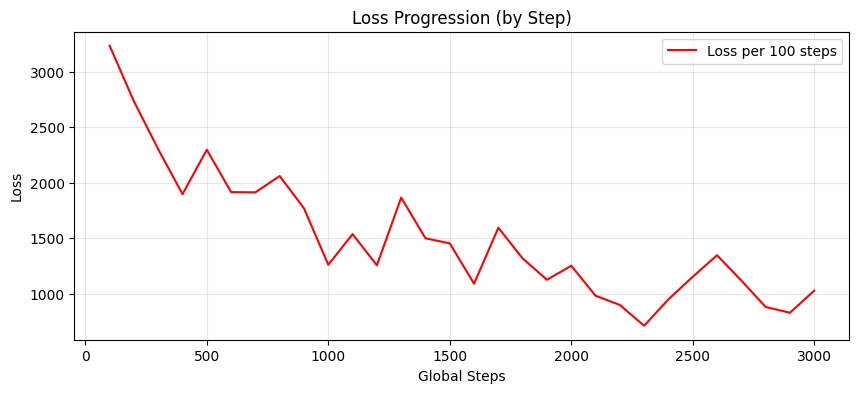

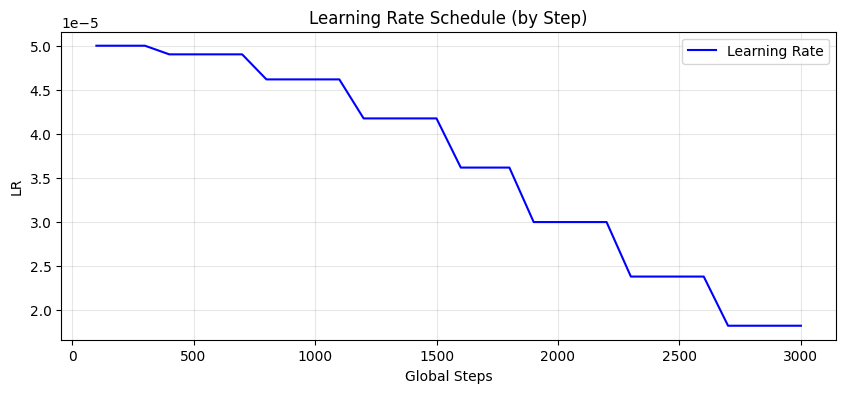

Lưu model tốt nhất tại: 954.2260
Step: 3100 | Epoch: 9 | Loss: 677.2678 | LR: 0.00001382
Step: 3200 | Epoch: 9 | Loss: 713.4277 | LR: 0.00001382
Step: 3300 | Epoch: 9 | Loss: 1141.2015 | LR: 0.00001382

--- KẾT THÚC EPOCH 9 ---
Average Loss: 888.6623


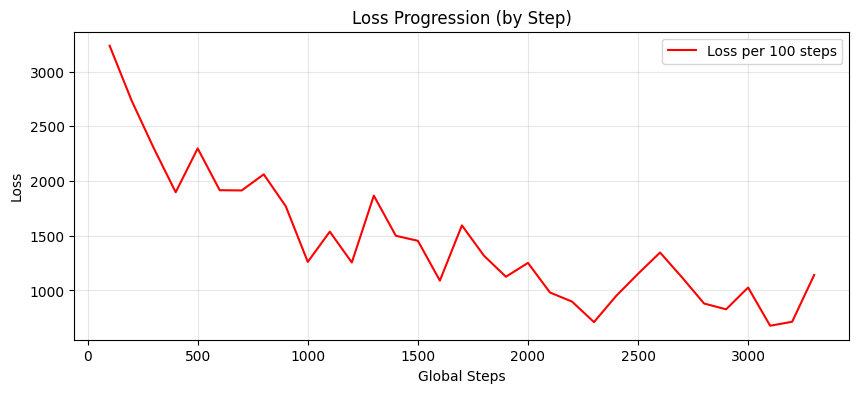

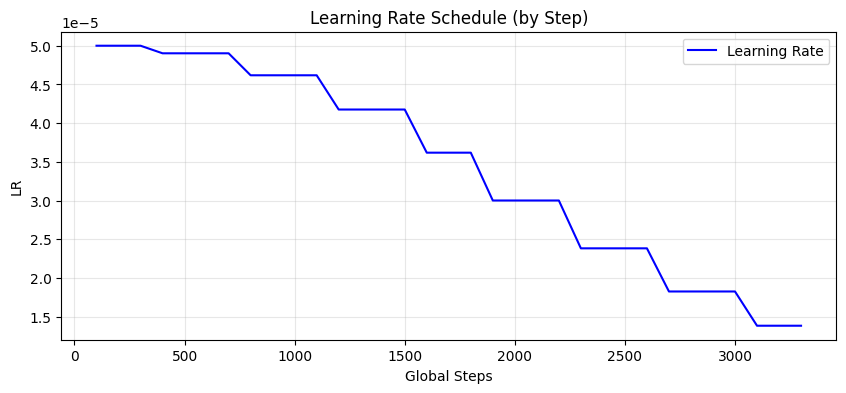

Lưu model tốt nhất tại: 888.6623
Step: 3400 | Epoch: 10 | Loss: 778.9154 | LR: 0.00001098
Step: 3500 | Epoch: 10 | Loss: 857.4794 | LR: 0.00001098
Step: 3600 | Epoch: 10 | Loss: 1072.1980 | LR: 0.00001098
Step: 3700 | Epoch: 10 | Loss: 681.4897 | LR: 0.00001098

--- KẾT THÚC EPOCH 10 ---
Average Loss: 839.3256


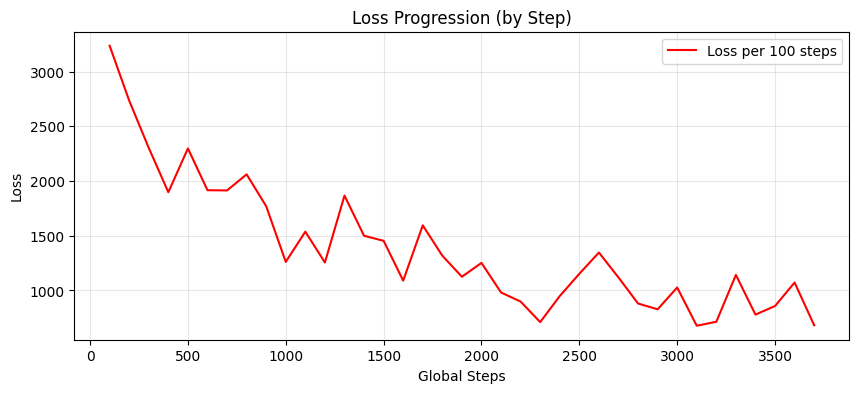

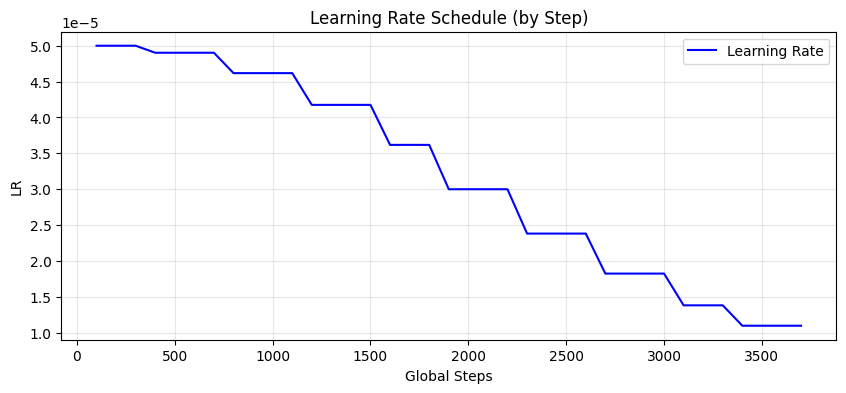

Lưu model tốt nhất tại: 839.3256


In [22]:
if __name__ == '__main__':
    train()